In [ ]:
# Gỡ cài đặt PyTorch và torchvision cũ
!pip uninstall torch torchvision -y

# Cài đặt phiên bản mới nhất
!pip install torch torchvision

# Khởi động lại runtime (nếu cần)
import os
os.kill(os.getpid(), 9)  # Tự động khởi động lại runtime để áp dụng thay đổi

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━

In [1]:
# Import thư viện
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [2]:
# Định nghĩa biến đổi dữ liệu
train_transforms = transforms.Compose([
    transforms.Resize((299, 299)),  # Inception V3 yêu cầu 299x299
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Tải dữ liệu CIFAR-10
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transforms)

# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 169M/169M [00:13<00:00, 12.6MB/s]


In [3]:
# Tải mô hình Inception V3
model = models.inception_v3(pretrained=True)

# Điều chỉnh tầng fully connected cuối cùng
model.fc = nn.Linear(model.fc.in_features, 100)

# Chuyển mô hình sang GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 60.9MB/s] 


In [4]:
# Hàm mất mát
criterion = nn.CrossEntropyLoss()

# Bộ tối ưu hóa
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [5]:
from torch.cuda.amp import GradScaler, autocast
import torch.optim.lr_scheduler as lr_scheduler
num_epochs = 25
batch_size = 128  # Tăng batch size (tùy GPU, có thể thử 256 nếu đủ bộ nhớ)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)  # Giảm LR sau mỗi 2 epoch
scaler = GradScaler()  # Mixed Precision

# Huấn luyện
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Mixed Precision Training
        with autocast():
            outputs = model(inputs)
            # Inception V3 trả về InceptionOutputs với logits và aux_logits
            loss = criterion(outputs.logits, labels)  # Chỉ dùng logits chính
            if model.aux_logits and outputs.aux_logits is not None:  # Kết hợp auxiliary loss
                aux_loss = criterion(outputs.aux_logits, labels)
                loss += 0.4 * aux_loss  # Trọng số 0.4 cho aux_loss (theo chuẩn Inception)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        if i % 100 == 99:  # In mỗi 100 mini-batch (ít thường xuyên hơn để nhanh hơn)
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}')
            running_loss = 0.0

    scheduler.step()

print(f"Huấn luyện hoàn tất! ")

<ipython-input-5-4ef0e8ba9069>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Mixed Precision
<ipython-input-5-4ef0e8ba9069>:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Epoch 1, Batch 100] Loss: 4.005
[Epoch 1, Batch 200] Loss: 2.524
[Epoch 1, Batch 300] Loss: 2.187
[Epoch 2, Batch 100] Loss: 1.576
[Epoch 2, Batch 200] Loss: 1.577
[Epoch 2, Batch 300] Loss: 1.520
[Epoch 3, Batch 100] Loss: 0.936
[Epoch 3, Batch 200] Loss: 0.833
[Epoch 3, Batch 300] Loss: 0.798
[Epoch 4, Batch 100] Loss: 0.570
[Epoch 4, Batch 200] Loss: 0.561
[Epoch 4, Batch 300] Loss: 0.631
[Epoch 5, Batch 100] Loss: 0.342
[Epoch 5, Batch 200] Loss: 0.299
[Epoch 5, Batch 300] Loss: 0.290
[Epoch 6, Batch 100] Loss: 0.184
[Epoch 6, Batch 200] Loss: 0.177
[Epoch 6, Batch 300] Loss: 0.189
[Epoch 7, Batch 100] Loss: 0.107
[Epoch 7, Batch 200] Loss: 0.097
[Epoch 7, Batch 300] Loss: 0.091
[Epoch 8, Batch 100] Loss: 0.062
[Epoch 8, Batch 200] Loss: 0.057
[Epoch 8, Batch 300] Loss: 0.063
[Epoch 9, Batch 100] Loss: 0.037
[Epoch 9, Batch 200] Loss: 0.038
[Epoch 9, Batch 300] Loss: 0.037
[Epoch 10, Batch 100] Loss: 0.026
[Epoch 10, Batch 200] Loss: 0.026
[Epoch 10, Batch 300] Loss: 0.026
[Epoch 

In [6]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# In kết quả
print(f"Tổng số tham số: {total_params:,}")
print(f"Số tham số có thể huấn luyện: {trainable_params:,}")

Tổng số tham số: 25,317,164
Số tham số có thể huấn luyện: 25,317,164


In [ ]:
torch.save(model.state_dict(), 'inception_cifar100.pth')

In [7]:
model.eval()  # Chuyển sang chế độ đánh giá
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Độ chính xác trên tập kiểm tra: {100 * correct / total:.2f}%')

Độ chính xác trên tập kiểm tra: 82.94%


In [ ]:
label_names = train_dataset.classes

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Lấy một batch hình ảnh từ test
# data_iter = iter(test_loader)
# images, labels = next(data_iter)


# fig, axes = plt.subplots(16, 8, figsize=(15, 15))
# axes = axes.flatten()

# for i in range(128):
#     img = images[i].numpy().transpose((1, 2, 0))  # Chuyển từ Tensor (C, H, W) -> (H, W, C)

#     # Hoàn tác quá trình chuẩn hóa
#     img = std * img + mean  # Đảo ngược chuẩn hóa
#     img = np.clip(img, 0, 1)  # Giới hạn giá trị trong khoảng [0,1] để hiển thị đúng

#     # Hiển thị ảnh
#     axes[i].imshow(img)
#     axes[i].axis('off')
#     axes[i].set_title(f'Label: {label_names[labels[i]]}', fontsize=10)

# plt.tight_layout()
# plt.show()

In [ ]:
model = models.inception_v3(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)
model.load_state_dict(torch.load('inception_v3_cifar10.pth'))
model = model.to(device)
model.eval()

In [8]:
class_names = test_dataset.classes

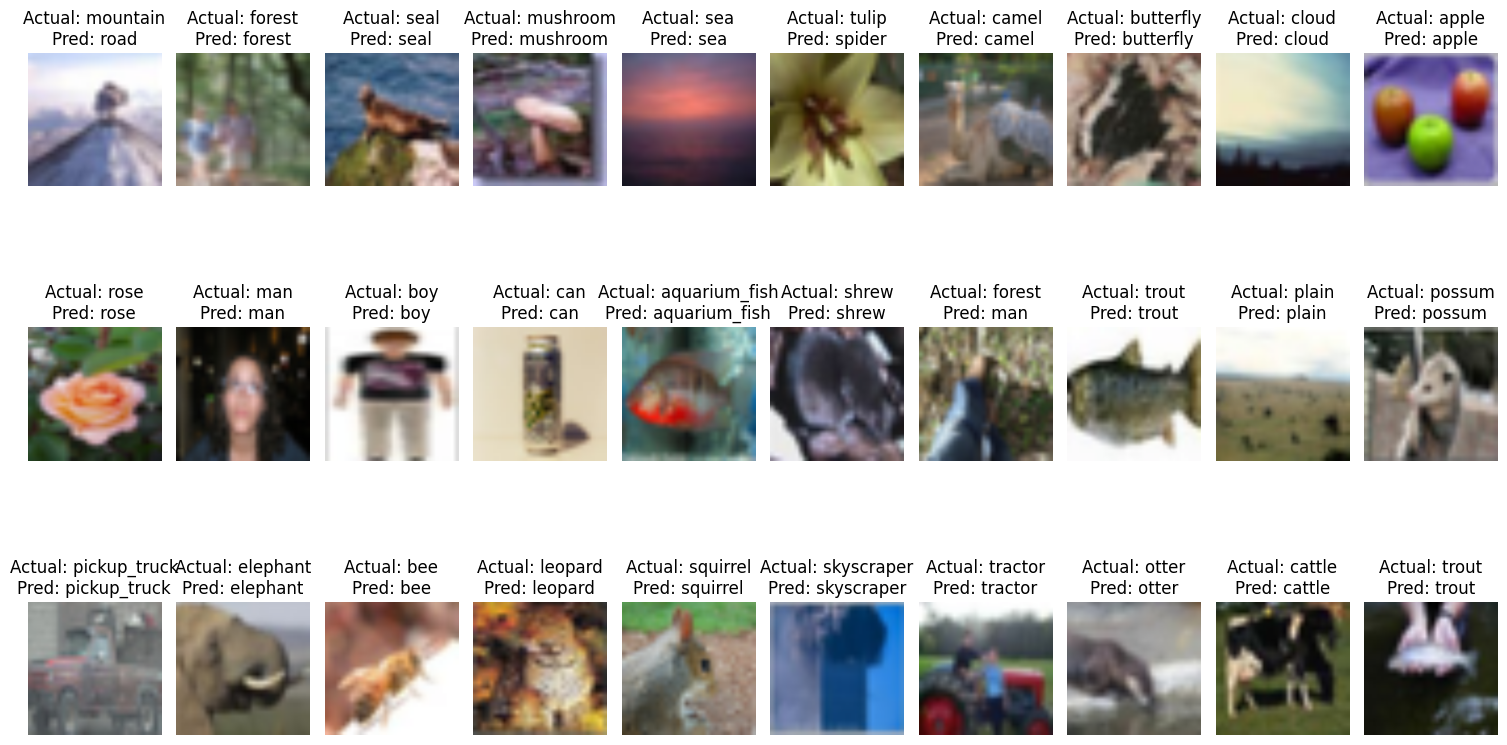

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Hàm hiển thị hình ảnh với đảo ngược chuẩn hóa
def imshow(img, title, mean, std):
    # Đảo ngược chuẩn hóa
    img = img.cpu()  # Chuyển về CPU
    for channel in range(3):  # Áp dụng cho từng kênh RGB
        img[channel] = img[channel] * std[channel] + mean[channel]
    img = img.numpy().transpose((1, 2, 0))  # Chuyển từ tensor sang numpy array

    # Đảm bảo giá trị nằm trong [0, 1]
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Hàm hiển thị hình ảnh từ số batch tùy chỉnh
def display_batches(test_loader, model, device, mean, std, num_batches=3, num_images_per_batch=5):
    model.eval()

    plt.figure(figsize=(15, 3 * num_batches))  # Điều chỉnh kích thước figure theo số batch

    with torch.no_grad():
        batch_count = 0
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            if batch_count >= num_batches:
                break

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # Hiển thị tối đa num_images_per_batch hình ảnh từ batch này
            for i in range(min(num_images_per_batch, len(labels))):
                plt.subplot(num_batches, num_images_per_batch, batch_count * num_images_per_batch + i + 1)
                actual = class_names[labels[i]] if 'class_names' in globals() else str(labels[i])
                pred = class_names[predicted[i]] if 'class_names' in globals() else str(predicted[i])
                title = f'Actual: {actual}\nPred: {pred}'
                imshow(inputs[i], title, mean, std)

            batch_count += 1

    plt.tight_layout()  # Điều chỉnh khoảng cách giữa các subplot
    plt.show()

# Giả sử đây là giá trị mean và std bạn đã dùng để chuẩn hóa
mean = [0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225] # Thay bằng giá trị của bạn nếu khác

# Gọi hàm với số batch tùy chỉnh
display_batches(test_loader, model, device, mean, std, num_batches=3, num_images_per_batch=10)  # Ví dụ: 3 batch, 5 ảnh mỗi batch

# Bạn có thể thay đổi số batch và số ảnh mỗi batch
# Ví dụ: display_batches(test_loader, model, device, mean, std, num_batches=2, num_images_per_batch=4)